In [1]:
import datetime
import os
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tools.train as train
import tools.models as models
import tools.plot as plot

Using TensorFlow backend.


In [2]:
# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Tensorboard logging
rightnow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nofftpath = os.path.join("..", "logs", rightnow, "nofft")

## Count data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs:
    inputs[key] = tf.expand_dims(inputs[key], axis=2)
train.class_count(df)


Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


In [3]:
largest_class_count = df["train"].groupby("Classes").size().max()
class_weights = np.divide(largest_class_count, df["train"].groupby("Classes").size().to_numpy())

print("Weighting the classes:", class_weights)

config = {
    "optimizer": "Nadam",
    "loss": "sparse_categorical_crossentropy",
    "class_weights": class_weights,
    "batch_size": 50,
    "val_split": 0.05,
    "epochs": 300,
    "verbose": 0,
    "patience": 50,
    "metrics": ["accuracy"],
}

inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]

LSTM_list = [(94,)]

# Make the LSTM network
model = models.create_lstm(LSTM_list, ncategories, config)

# Train
history = train.train_print(model, inputs, sparse_labels, config)

Weighting the classes: [  1.          32.60053981  12.52090532 113.05928237  11.26900949]
Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 94)                36096     
_________________________________________________________________
dense (Dense)                (None, 5)                 475       
Total params: 36,571
Trainable params: 36,571
Non-trainable params: 0
_________________________________________________________________

Training

Train acc: 0.9924047
Test acc: 0.9831902


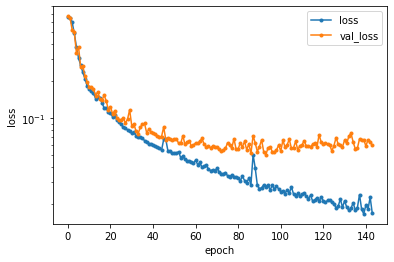

Confusion matrix, without normalization
[[18004    64    25     4    21]
 [  115   429    11     0     1]
 [   44     5  1380    15     4]
 [   26     1    15   120     0]
 [   13     1     3     0  1591]]


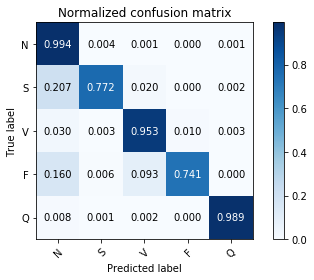

In [6]:
plot.plot_fit_history(history)

test_pred = np.argmax(model.predict(inputs["test"]), axis=1)
plot.plot_cm(
    sparse_labels["test"],
    test_pred,
    classes=np.array(["N", "S", "V", "F", "Q"]),
    normalize=True,
    norm_fmt=".3f",
)

# Save the model
if not os.path.exists(os.path.join("..", "models", rightnow, "nofft")):
    os.makedirs(os.path.join("..", "models", rightnow, "nofft"))
model.save(os.path.join("..", "models", rightnow, "nofft", "LSTM.h5"))